# Reading DICOM scans an saving as numpy arrays

In [10]:
import os
from pathlib import Path
from collections import Counter

import numpy as np

In [2]:
from lunglens.data import *

Microsoft Visual C++ Redistributable is not installed, this may lead to the DLL load failure.
                 It can be downloaded at https://aka.ms/vs/16/release/vc_redist.x64.exe


In [4]:
data_dir = Path('../data/extracted')
dest_root_dir = Path('../data/prepared')

## Kaggle: OSIC Pulmonary Fibrosis Progression

In [5]:
ds_dir = data_dir/'osic-pulmonary-fibrosis-progression'
dest_dir = dest_root_dir/'osic-pulmonary-fibrosis-progression/'

In [8]:
all_scans = list(ds_dir.rglob('ID0*'))

In [17]:
convert_dicoms2np(all_scans, dest_dir)

error occured when trying to save scan: ..\data\extracted\osic-pulmonary-fibrosis-progression\train\ID00052637202186188008618
Exception thrown in SimpleITK ImageSeriesReader_Execute: D:\a\1\sitk-build\ITK\Modules\IO\GDCM\src\itkGDCMImageIO.cxx:307:
itk::ERROR: itk::ERROR: GDCMImageIO(00000267A6396260): Failed to change to Implicit Transfer Syntax



In [19]:
all_files = list(dest_dir.glob('*/*.npy'))

scans_folders = [f.parent.name for f in all_files]

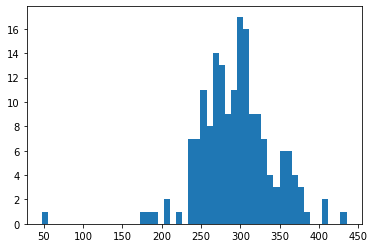

In [25]:
scan_sizes = list(Counter(scans_folders).values())

print_hist(np.array(scan_sizes))

## COVID19_1110 dataset

In [46]:
ds_dir = data_dir/'COVID19_1110'
dest_dir = dest_root_dir/'COVID19_1110'

In [47]:
all_files = list(ds_dir.rglob('*.nii'))

len(all_files)

1110

In [48]:
convert_dicoms2np(all_files, dest_dir)